# Classifying Ising model phase transitions using FNNs in PyTorch

April 25, 2022

This code relies on work from Lauren Hayward, Juan Carrasquilla, and Mohamed Hibat Allah. <br/>
Dataset generated using Monte Carlo sampling also by the Lauren, Juan and Mohamed.

### Import libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from IPython import display
import time
import copy
from sklearn.model_selection import train_test_split

### Import data

In [2]:
github_dir = 'https://raw.githubusercontent.com/sofiagonga/ML_manybody_physics/main/ising_phase_classifier/data'

x_url = os.path.join(github_dir, 'x_L30.txt')
y_url = os.path.join(github_dir, 'y_L30.txt')
T_url = os.path.join(github_dir, 'T_L30.txt')

x_all = np.loadtxt(x_url , dtype='int16')
y_all = np.loadtxt(y_url , dtype='int16')
T_all = np.loadtxt(T_url , dtype='int16')

In [3]:
N_configs = np.shape(x_all)[0]
print("Number of configurations in data set: ", N_configs)

L = int(np.sqrt(np.shape(x_all)[1]))
print("Lattice size: ", L, 'x', L)

Number of configurations in data set:  10000
Lattice size:  30 x 30


#### Select GPU to run code if available (speeds-up calculation)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device available:", device) #M1 chip does not support GPU as of today

Device available: cpu


### Plot a random configuration


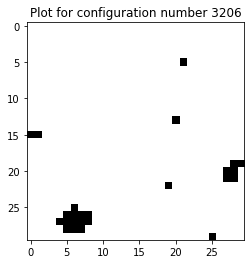

In [5]:
rnd_config_index = np.random.randint(0, N_configs)
reshaped_configuration = x_all[rnd_config_index].reshape(L,L)

title = 'Plot for configuration number ' + str(rnd_config_index)
plt.title(title)
plt.imshow(reshaped_configuration, cmap=plt.cm.gray) #black = 0, white = 1
plt.show()

## Define the network architecture

In [6]:
%matplotlib inline

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, output_size, nl_h1):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size

        #activation functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, nl_h1)
        self.linear2 = torch.nn.Linear(nl_h1, self.output_size)
        
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
        
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        a1 = self.sigmoid(linear1_out)
        #Layer 2:
        linear2_out = self.linear2(a1)
        a2 = self.sigmoid(linear2_out)

        #Network output:
        aL = a2

        return aL

### Define model creation function
(Avoids training model on pre-existing model)

In [7]:
def define_model(nl_h1):
    input_size = L*L
    output_size = 2
    #nl_h1 = number of neurons in hidden layer 1

    model = FeedforwardNN(input_size, output_size, nl_h1).to(device)
    
    return model

### Define the cost function

In [8]:
cost_func = torch.nn.MSELoss()
#Other: cost_func = torch.nn.CrossEntropy()

### Define model training function

In [9]:
def train_model(N_epochs, x_train, x_val, y_train, y_val, y_onehot_train, y_onehot_val, lr, nl_h1 = 100, wd = 0):
    epoch_list    = []
    cost_training = []
    acc_training  = []
    cost_validation = []
    acc_validation  = []
    
    model = define_model(nl_h1)
    optimizer = torch.optim.SGD(model.parameters(), lr, wd)
    
    ### Train for several epochs: ###
    for epoch in range(N_epochs):

        optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
        NN_output_train = model(x_train) # Neural network output for training
        NN_output_val = model(x_val) # Neural network output for validation
        cost_train = cost_func(NN_output_train, y_onehot_train)
        cost_valid = cost_func(NN_output_val, y_onehot_val)

        cost_train.backward() #computes the gradients
        cost_valid.backward() #computes the gradients

        optimizer.step() #updating the parameters 

        if epoch % 50 == 0:
            epoch_list.append(epoch)

            #Training data
            predicted_class_train = np.argmax(NN_output_train.detach().numpy(), axis=1)
            accuracy_train = np.mean(predicted_class_train == y_train)

            cost_training.append(cost_train.detach().numpy())
            acc_training.append(accuracy_train)

            #Validation data
            predicted_class_valid = np.argmax(NN_output_val.detach().numpy(), axis=1)
            accuracy_valid = np.mean(predicted_class_valid == y_val)

            cost_validation.append(cost_valid.detach().numpy())
            acc_validation.append(accuracy_valid)
            
    return epoch_list, cost_training, cost_validation, acc_training, acc_validation

### Split data into training, validation and testing

In [10]:
split_ratio = [0.7, 0.2, 0.1] #train, validate, test

first_split = split_ratio[1] + split_ratio[2]
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size = first_split, random_state=1)

second_split = split_ratio[2]/(split_ratio[1] + split_ratio[2])
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = second_split, random_state=1)

In [11]:
### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float).to(device)
x_val = torch.tensor(x_val, dtype = torch.float).to(device)

### One hot encoding for training data set###
y_onehot_train = np.zeros((y_train.size, 2))
y_onehot_train[np.arange(y_train.size), y_train] = 1
y_onehot_train = torch.tensor(y_onehot_train, dtype = torch.float).to(device)

### One hot encoding for validation data set###
y_onehot_val = np.zeros((y_val.size, 2))
y_onehot_val[np.arange(y_val.size), y_val] = 1
y_onehot_val = torch.tensor(y_onehot_val, dtype = torch.float).to(device)

### Function for plotting

In [12]:
def plot_fnn_params(epoch_list, parameter_values_train, parameter_values_valid, parameter_name):
    title = str(parameter_name) + ' evolution with epoch'
    plt.title(title)
    plt.plot(epoch_list, parameter_values_train, label = 'Training data', ls = 'dashed')
    plt.plot(epoch_list, parameter_values_valid, label = 'Validation data', ls = 'dashed')
    plt.xlabel('Epoch')
    plt.ylabel(parameter_name)
    plt.legend()
    plt.show()

##  <span style="color:#8B008B"> Training (2.a) </span>

#### Define hyperparameters

In [13]:
learning_rate = 1
N_epochs = 1000 # number of times to run gradient descent

#### Train model

In [14]:
epoch_list, cost_training, cost_validation, acc_training, acc_validation = train_model(N_epochs, x_train, x_val, y_train, y_val, y_onehot_train, y_onehot_val, learning_rate)

In [15]:
#### Plot results

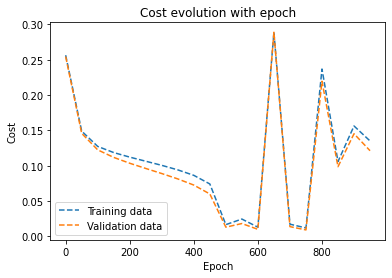

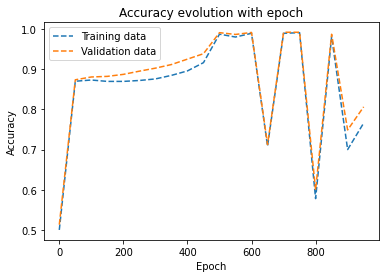

Final Training cost 0.135114
Final Training accuracy 0.766109

Final Validation cost 0.121307
Final Validation accuracy 0.806500



In [16]:
plot_fnn_params(epoch_list, cost_training, cost_validation, 'Cost')
plot_fnn_params(epoch_list, acc_training, acc_validation, 'Accuracy')

print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost_training[-1], acc_training[-1]) )
print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (cost_validation[-1], acc_validation[-1]) )

##  <span style="color:#8B008B"> Training (2.b) </span>

### Compare different values of weight decay

In [17]:
learning_rate = 1
N_epochs = 3000 # number of times to run gradient descent

In [18]:
weight_decays = [1e-2, 1e-5, 1e-10, 1e-15]

for weight_decay in weight_decays:
    epoch_list, cost_training, cost_validation, acc_training, acc_validation = train_model(N_epochs, x_train, x_val, y_train, y_val, y_onehot_train, y_onehot_val, lr = learning_rate, wd = weight_decay)
    
    print("Results for weight decay: ", weight_decay)
    plot_fnn_params(epoch_list, cost_training, cost_validation, 'Cost')
    plot_fnn_params(epoch_list, acc_training, acc_validation, 'Accuracy')
    print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost_training[-1], acc_training[-1]) )
    print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (cost_validation[-1], acc_validation[-1]) )
    print("")

KeyboardInterrupt: 

##  <span style="color:#8B008B"> Tuning hyper parameters (2.c) </span>

### Number of neurons in hidden layer

In [ ]:
learning_rate = 1
N_epochs = 3000 # number of times to run gradient descent

In [ ]:
nl_h1_s = [10, 50, 100, 200] #number of neurons in hidden layer

for nl_h1 in nl_h1_s:
    epoch_list, cost_training, cost_validation, acc_training, acc_validation = train_model(N_epochs, x_train, x_val, y_train, y_val, y_onehot_train, y_onehot_val, lr = learning_rate, nl_h1)
    
    print("Results for weight decay: ", weight_decay)
    plot_fnn_params(epoch_list, cost_training, cost_validation, 'Cost')
    plot_fnn_params(epoch_list, acc_training, acc_validation, 'Accuracy')
    print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost_training[-1], acc_training[-1]) )
    print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (cost_validation[-1], acc_validation[-1]) )
    print("")

### Learning rate

In [ ]:
N_epochs = 3000

In [ ]:
learning_rates = [0.1, 0.5, 1, 2]

for learning_rate in learning_rates:
    epoch_list, cost_training, cost_validation, acc_training, acc_validation = train_model(N_epochs, x_train, x_val, y_train, y_val, y_onehot_train, y_onehot_val, lr = learning_rate)
    
    print("Results for weight decay: ", weight_decay)
    plot_fnn_params(epoch_list, cost_training, cost_validation, 'Cost')
    plot_fnn_params(epoch_list, acc_training, acc_validation, 'Accuracy')
    print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost_training[-1], acc_training[-1]) )
    print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (cost_validation[-1], acc_validation[-1]) )
    print("")

##  <span style="color:#8B008B"> Test best model on testing data (2.d) </span>

### Define best hyper parameters

In [ ]:
learning_rate = 1
N_epochs = 3000 # number of times to run gradient descent
nl_h1 = 100
weight_decay = 0